# Machine Learning Project
- Team: NULL & Void
- Objective: Predict House Sale Price (Ames, IA)

In [1]:
import numpy as np
import pandas as pd
import math
from pandas import Series, DataFrame
from scipy import stats
from scipy.stats import (spearmanr,skew)
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn import linear_model
from sklearn.linear_model import (LinearRegression,Ridge,RidgeCV,LassoCV,ElasticNet,ElasticNetCV,Lasso,LassoLarsCV)
from sklearn.decomposition import PCA
from sklearn.svm import SVR

from sklearn.preprocessing import (scale,LabelEncoder)
from collections import Counter
from sklearn.model_selection import(cross_val_score,cross_val_predict,train_test_split,StratifiedKFold,GridSearchCV,KFold,RandomizedSearchCV)
from sklearn.feature_selection import(SelectKBest,VarianceThreshold,chi2)
from sklearn.ensemble import(RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor)
from sklearn.metrics import(mean_absolute_error,mean_squared_error,r2_score,explained_variance_score)
from vecstack import stacking
import xgboost as xgb

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Initial Data Processing#
- Data was pre-processed in R, additional processing completed below:

    - Eliminate outliers from Train set. 
    - Log Transformation of the target variable, Sale Price.

In [2]:
#Read In Data
nullandvoid = pd.read_csv('clean_final.csv')
nullandvoid.shape

(2919, 85)

In [3]:
#Removed 4 observations that are supposed to be outliers The 5th outlier is part of the test group (not removed). 
outlier = np.log(4000)
outlier_exclude = nullandvoid.loc[nullandvoid['Set'] == 'Train']
outlier_exclude = outlier_exclude[(outlier_exclude['GrLivArea']<outlier)]
outlier_exclude.shape

(1456, 85)

In [4]:
test_include=nullandvoid.loc[nullandvoid['Set'] == 'Test']
test_include.shape

(1459, 85)

In [5]:
#New Complete DataFrame (excluding outliers)
complete_df = pd.concat([outlier_exclude,test_include])

In [6]:
#Create Predictor Target Variable
y_target = complete_df.loc[complete_df['Set'] == 'Train']["SalePrice"]
y_target = np.log(y_target.astype(float))
y_target_df = pd.Series.to_frame(y_target)

In [7]:
#Create data set for EDA
nullandvoid_ID = complete_df.loc[:,('Id','Set')]
nullandvoid_ = complete_df.copy()
nullandvoid_ = nullandvoid_.loc[complete_df['Set'] == 'Train']
nullandvoid_.drop("Id", axis = 1, inplace = True)
nullandvoid_.drop("Set", axis = 1, inplace = True)
nullandvoid_.drop('SalePrice', axis=1, inplace = True)
nullandvoid_featurelist = nullandvoid_.copy()

# Exploratory Data Analysis#

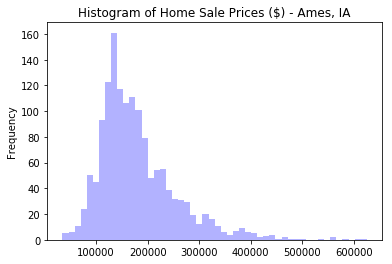

In [8]:
complete_df.SalePrice.plot(kind='hist',bins=50,color='b', alpha = 0.3)
plt.title('Histogram of Home Sale Prices ($) - Ames, IA')
plt.show()

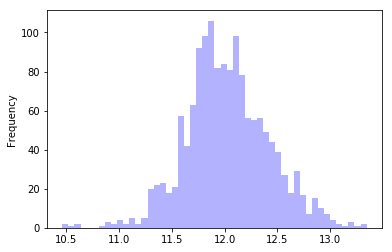

In [9]:
y_target.plot(kind='hist',bins=50,color='b', alpha = 0.3)
plt.show()

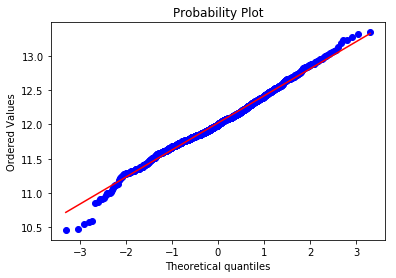

In [10]:
stats.probplot(y_target_df['SalePrice'], plot=plt)
plt.show()

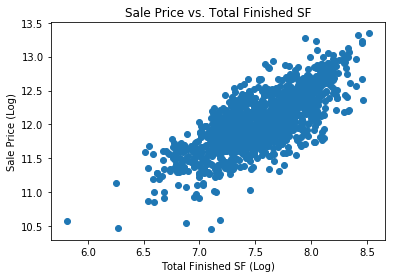

In [13]:
plt.scatter(nullandvoid_featurelist["TotalFinSF"], y_target_df["SalePrice"])
plt.title("Sale Price vs. Total Finished SF")
plt.ylabel("Sale Price (Log)")
plt.xlabel("Total Finished SF (Log)")
plt.show()

In [85]:
correlation = nullandvoid_featurelist.corr()
correlation.to_csv('correlation.csv')

In [86]:
correlation1 = correlation[correlation.apply(lambda x:  x > .5)]
correlation2 = correlation[correlation.apply(lambda x:  x < -.5)]

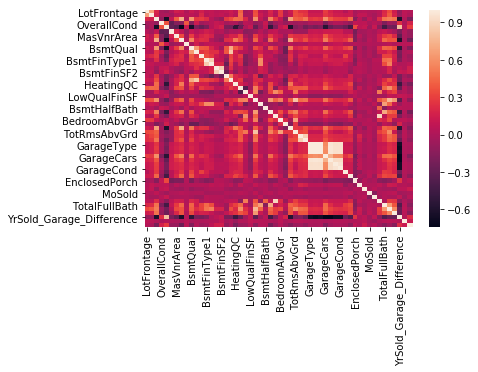

In [87]:
sb.heatmap(correlation)
plt.show()

In [88]:
#Adjust Feature Set (Handle Multicollinearity and Repeat Attributes)
nav_featurelist=complete_df.copy()

#Drop Lot Frontage and Keep Lot Area
nav_featurelist.drop('LotFrontage', axis = 1, inplace = True)

#Create a Quality Indicator Score 
nav_featurelist['AverageQual'] = nav_featurelist[['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu']].mean(axis = 1)
nav_featurelist.drop(['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu'], axis = 1, inplace = True)

#DataFrame contains Total Living Area
nav_featurelist.drop(['GrLivArea','X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'BsmtFinSF2', 'BsmtFinSF1'], axis = 1, inplace = True)

#DataFrame contains Total Full and Half Bath
nav_featurelist.drop(['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'], axis = 1, inplace = True)

#GarageType, GarageYrBlt, GarageFinish, GarageArea, GarageQual, GarageCond
nav_featurelist.drop(['GarageType','GarageYrBlt','GarageFinish','GarageArea','GarageQual','GarageCond'], axis = 1, inplace = True)

#Already created feature YrSold - GarageYrBlt
nav_featurelist.drop('YrSold', axis = 1, inplace = True)

#AbvGrndRoomSize collinear with TotRmsAbvGrnd
nav_featurelist.drop('AbvGrndRoomSize', axis = 1, inplace = True)


In [89]:
nav_adj_features = pd.get_dummies(nav_featurelist,drop_first=True)
nav_org_features = pd.get_dummies(complete_df,drop_first=True)

In [90]:
nav_org_features.columns
nav_org_features.loc[:,"SalePrice"]
nav_org_features.head()
#complete_df.loc[:,"YearBuilt"]

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,hasDeck_Yes,hasOpenPorch_Yes,hasEnlosedPorch_Yes,hasX3SsnPorch_Yes,hasScreenPorch_Yes,Set_Train
0,1,65.0,9.041922,7,5,1.791759,1,5.283204,3,2,...,0,0,1,0,0,1,0,0,0,1
1,2,80.0,9.169518,6,8,3.465736,1,0.000000,2,2,...,0,0,1,0,1,0,0,0,0,1
2,3,68.0,9.328123,7,5,2.079442,0,5.093750,3,2,...,0,0,1,0,0,1,0,0,0,1
3,4,60.0,9.164296,7,5,4.521789,0,0.000000,2,2,...,0,0,0,0,0,1,1,0,0,1
4,5,84.0,9.565214,8,5,2.197225,1,5.860786,3,2,...,0,0,1,0,1,1,0,0,0,1


In [91]:
train_org_features = nav_org_features.loc[nav_org_features['Set_Train'] == 1]
test_org_features = nav_org_features.loc[nav_org_features['Set_Train'] == 0]

train_adj_features = nav_adj_features.loc[nav_adj_features['Set_Train'] == 1]
test_adj_features = nav_adj_features.loc[nav_adj_features['Set_Train'] == 0]

In [92]:
train_org_features.drop("Id", axis = 1, inplace = True)
test_org_features.drop("Id", axis = 1, inplace = True)
train_adj_features.drop("Id", axis = 1, inplace = True)
test_adj_features.drop("Id", axis = 1, inplace = True)

train_org_features.drop("Set_Train", axis = 1, inplace = True)
test_org_features.drop("Set_Train", axis = 1, inplace = True)
train_adj_features.drop("Set_Train", axis = 1, inplace = True)
test_adj_features.drop("Set_Train", axis = 1, inplace = True)

train_org_features.drop("SalePrice", axis = 1, inplace = True)
test_org_features.drop("SalePrice", axis = 1, inplace = True)
train_adj_features.drop("SalePrice", axis = 1, inplace = True)
test_adj_features.drop("SalePrice", axis = 1, inplace = True)

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing import

In [93]:
print(train_adj_features.shape)
print(train_org_features.shape)

print(test_adj_features.shape)
print(test_org_features.shape)

(1456, 149)
(1456, 172)
(1459, 149)
(1459, 172)


# Machine Learning Algorithms #

In [94]:
#Create the Train and Validation Data Sets (Original)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(train_org_features, y_target, test_size = .2, random_state = 42)

In [95]:
#Create the Train and Validation Data Sets (Fields Dropped)
X_train, X_test, y_train, y_test = train_test_split(train_adj_features, y_target, test_size = .2, random_state = 42)

In [96]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [97]:
def rmsle(y_pred,y_true):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

### Lasso Regression##

In [109]:
lasso_para = {'alpha': np.logspace(.0001,.001)-1}
l_m = Lasso()
l_gs2 = GridSearchCV(l_m, lasso_para, cv = 5)
l_gs2.fit(X_train_orig, y_train_orig)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.00023, 0.00027, 0.00031, 0.00036, 0.0004 , 0.00044, 0.00048,
       0.00053, 0.00057, 0.00061, 0.00065, 0.0007 , 0.00074, 0.00078,
       0.00082, 0.00087, 0.00091, 0.00095, 0.00099, 0.00103, 0.00108,
       0.00112, 0.00116, 0.0012 , 0.00125, 0.00129, 0.00133, 0.00137,...92, 0.00197,
       0.00201, 0.00205, 0.00209, 0.00214, 0.00218, 0.00222, 0.00226,
       0.00231])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [110]:
l_gs2.score(X_test_orig, y_test_orig)

0.909608034384885

In [111]:
print(rmse(l_gs2.predict(X_test_orig),y_test_orig))
rmsle(l_gs2.predict(X_test_orig),y_test_orig)

0.11948458399775586


0.00940344467078044

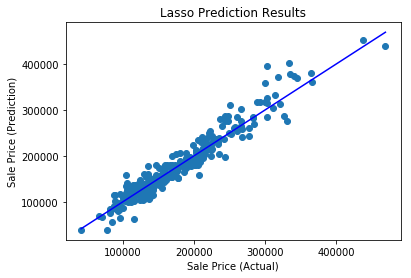

In [112]:
pred_train = np.expm1(l_gs2.predict(X_test_orig))
plt.scatter(pred_train, np.expm1(y_test_orig))
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="blue")
plt.title("Lasso Prediction Results")
plt.ylabel("Sale Price (Prediction)")
plt.xlabel("Sale Price (Actual)")
plt.show()

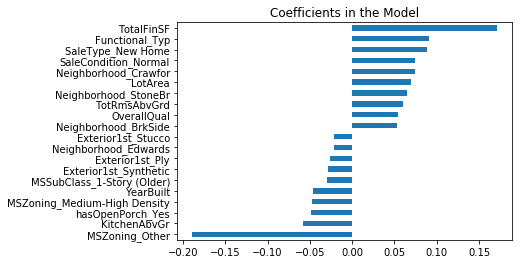

In [113]:
coef = pd.Series(l_gs2.best_estimator_.coef_, index = X_train_orig.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")
plt.show()

In [117]:
len(l_gs2.best_estimator_.coef_)

172

In [118]:
print(l_gs2.best_params_)
print(l_gs2.best_estimator_)
print(l_gs2.best_score_)

{'alpha': 0.0004841299379423347}
Lasso(alpha=0.0004841299379423347, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.9154836628302392


### Ridge regression ##

In [120]:
parameters = {'alpha': np.logspace(.00001,10)-1}
ridge_m = Ridge()
ridge_gs2 = GridSearchCV(ridge_m, parameters, cv = 5)
ridge_gs2.fit(X_train_orig, y_train_orig)
print(ridge_gs2.best_estimator_)
print(ridge_gs2.best_score_)

Ridge(alpha=9.481348054533898, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.9157026849132923


In [121]:
ridge_gs2.score(X_test_orig, y_test_orig)

0.9077387807933469

In [122]:
print(rmse(ridge_gs2.predict(X_test_orig),y_test_orig))
print(rmsle(ridge_gs2.predict(X_test_orig),y_test_orig))

0.1207136982308432
0.009513233300244764


In [127]:
print(ridge_gs2.best_params_)
print(ridge_gs2.best_score_)

{'alpha': 9.481348054533898}
0.9157026849132923


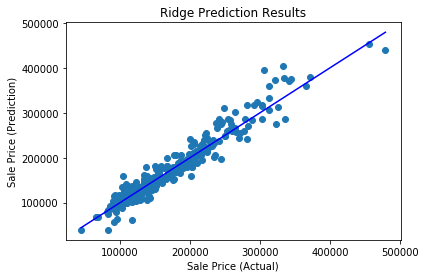

In [124]:
pred_train = np.expm1(ridge_gs2.predict(X_test_orig))
plt.scatter(pred_train, np.expm1(y_test_orig))
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="blue")
plt.title("Ridge Prediction Results")
plt.ylabel("Sale Price (Prediction)")
plt.xlabel("Sale Price (Actual)")
plt.show()

### Multiple Linear Regression ###

In [139]:
#Using Lasso for feature selection
lassoreg = Lasso(0.0004841299379423347)
lassoreg.fit(X_train_orig, y_train_orig)

cols = X_train_orig.columns.tolist()
lasso_drop = list()

for i in list(np.where(lassoreg.coef_ == 0)[0]):
    lasso_drop.append(cols[i])

In [140]:
X_features_drop = X_train_orig.drop(lasso_drop, axis = 1, inplace = False)

Xtest_features_drop = X_test_orig.drop(lasso_drop, axis = 1, inplace = False)

In [141]:
mlr_m = LinearRegression()
mlr_m.fit(X_features_drop, y_train_orig)
mlr_m.score(Xtest_features_drop, y_test_orig)

0.9083492426294753

In [142]:
rmse(mlr_m.predict(Xtest_features_drop),y_test_orig)

0.12031367420749561

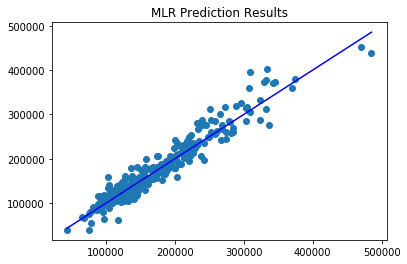

In [143]:
pred_train = np.expm1(mlr_m.predict(Xtest_features_drop))
plt.scatter(pred_train, np.expm1(y_test_orig))
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="blue")
plt.title("MLR Prediction Results")
plt.show()

In [137]:
#Mitch?
# mlr_m = LinearRegression()
# mlr_m.fit(X_train, y_train)
# mlr_m.score(X_test, y_test)

-13895329.050354073

### Random forest ###

In [175]:
rf_m_orig = RandomForestRegressor()

rf_para_orig = [{
'max_depth': [17],
'n_estimators': [239],
'min_samples_leaf' : [5],
'min_samples_split': [10],
'max_features': ['sqrt'],
'random_state': [2]
}]

rf_gs_origdummies = GridSearchCV(estimator = rf_m_orig, param_grid = rf_para_orig, cv = 5, n_jobs = -1)
rf_gs_origdummies.fit(X_train_orig, y_train_orig)

print(rf_gs_origdummies.best_params_)
rf_gs_origdummies.best_score_

{'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 239, 'random_state': 2}


0.8666443838960801

In [158]:
print(rmse(rf_gs_origdummies.predict(X_test_orig),y_test_orig))
print(rmsle(rf_gs_origdummies.predict(X_test_orig),y_test_orig))

0.15414900956731784
0.0121245415861795


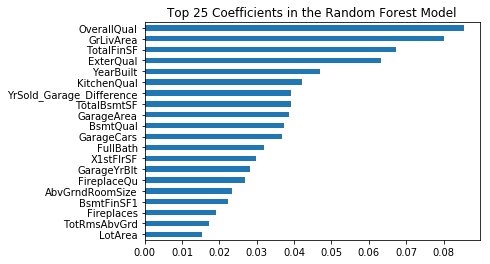

In [174]:
coef = pd.Series(rf_gs_origdummies.best_estimator_.feature_importances_, index = X_train_orig.columns).sort_values()
imp_coef = pd.concat([coef.tail(20)])
imp_coef.plot(kind = "barh")
plt.title("Top 25 Coefficients in the Random Forest Model")
plt.show()

In [176]:
#coef[coef>0]

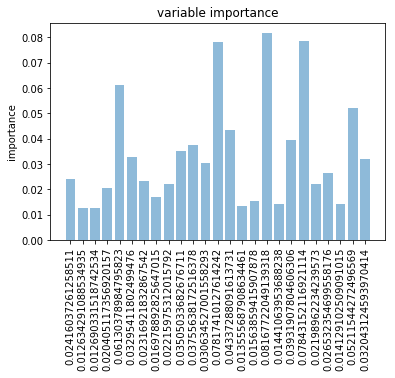

In [177]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
          max_features='sqrt', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=5, min_samples_split=10,
          min_weight_fraction_leaf=0.0, n_estimators=239, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
model_1 = rf.fit(X_train_orig, y_train_orig)
feature_imp = pd.DataFrame(sorted(list(zip(X_train_orig.columns, model_1.feature_importances_)), key = lambda x: x[1], reverse=True)[0:25])
plt.bar(feature_imp[0], feature_imp[1], align='center', alpha=0.5)
plt.xticks(feature_imp[0], feature_imp[1])
plt.ylabel('importance')
plt.title('variable importance')
plt.xticks(rotation=90)
plt.show()

### XG Boost###

In [178]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
regr.fit(X_train_orig, y_train_orig)
print(rmse(regr.predict(X_test_orig),y_test_orig))
rmsle(regr.predict(X_test_orig),y_test_orig)

0.12398122560091158


0.009802246545651387

In [179]:
regr.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)>

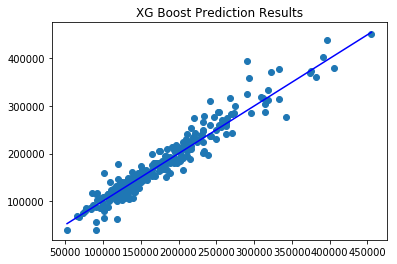

In [180]:
pred_train = np.expm1(regr.predict(X_test_orig))
plt.scatter(pred_train, np.expm1(y_test_orig))
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="blue")
plt.title("XG Boost Prediction Results")
plt.show()

### Gradient Boosting Regression ###

In [181]:
gbr_para = {'learning_rate': np.arange(.01,1,.005), 'subsample': np.arange(.1,1,.1)}
gbr_m = GradientBoostingRegressor(n_estimators = 400, min_samples_split = 10, max_depth = 2, max_features = 12)
gbr_gs = GridSearchCV(gbr_m, gbr_para)
gbr_gs.fit(X_train_orig, y_train_orig)
print(gbr_gs.best_estimator_)
print(gbr_gs.best_score_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.06999999999999999, loss='ls', max_depth=2,
             max_features=12, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=None, subsample=0.6, verbose=0,
             warm_start=False)
0.9117892563670562


In [252]:
print(rmse(gbr_gs.predict(X_test_orig),y_test_orig))
rmsle(gbr_gs.predict(X_test_orig),y_test_orig)

0.131074439418


0.010271732304486005

# Ensembling Models ###
- Leverged Both Averaging and Stacking Methods for our MLR Models

### Averaging###

In [264]:
# ##Creating feature set for final round of averaging (MLR)
# Xtest_mlr = test_org_features.drop(lasso_drop, axis = 1, inplace = False)

(1164, 107)

In [194]:
avg_test=((ridge_gs2.predict(X_test_orig)) + (l_gs2.predict(X_test_orig)) + (gbr_gs.predict(X_test_orig)) + 
          (regr.predict(X_test_orig)))/4 

In [195]:
print(rmse(avg_test,y_test))
print(rmsle(avg_test,y_test))

0.11668570147013792
0.009209450310960696


In [198]:
test_prediction=((ridge_gs2.predict(test_org_features)) + (l_gs2.predict(test_org_features)) + (gbr_gs.predict(test_org_features)) + 
          (regr.predict(test_org_features)))/4 

#test_prediction=(ridge_gs2.predict(test_org_features) + l_gs2.predict(test_org_features)
#     + regr.predict(test_org_features))/3 
#+ regr.predict(test_org_features)
#gbr_gs.predict(test_org_features)
#+ rf_gs_orig.predict(test_org_features)

In [199]:
id_ = nullandvoid.loc[nullandvoid['Set'] == 'Test']["Id"]
outAverage = pd.DataFrame({'Id': id_, 'SalePrice': np.exp(test_prediction)})

#id_.reset_index()
#ex_.reset_index()
print(id_.shape)
print(outAverage.shape)

(1459,)
(1459, 2)


In [200]:
outAverage.to_csv("finaltest.csv")

### Stacking

In [202]:
models = [
    
    Lasso(alpha = 0.0004841299379423347),
    
    RandomForestRegressor(max_depth = 17, max_features = 'sqrt', min_samples_leaf = 5, min_samples_split = 10, n_estimators = 239),
    
    Ridge(alpha=9.481348054533898, copy_X=True, fit_intercept=True, 
          max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001),
    
    GradientBoostingRegressor(alpha = .9, min_samples_split = 10, 
                                    max_depth = 2, max_features = 12, n_estimators = 400,
                                    learning_rate = .069999999999999991)
    ]

meta_model = LinearRegression(normalize=True)

In [207]:
final_prediction = stacking_regression(models, meta_model, X_train_orig, y_train_orig.as_matrix(), test_org_features,
                                       transform_target=np.log1p, transform_pred = np.expm1, 
                                       metric=rmsle, verbose=1)

In [279]:
final_prediction.shape

(1459,)

In [281]:
id_ = nullandvoid.loc[nullandvoid['Set'] == 'Test']["Id"]
outStack = pd.DataFrame({'Id': id_, 'SalePrice': np.exp(final_prediction)})

outStack.to_csv("stacktest.csv")

In [280]:
final_prediction[:5] 

array([ 11.63177543,  12.00429634,  12.08667338,  12.15550973,  12.15471567])

# Apendix#
- Includes Machine Learning Models attempted with alternative pre-processing methodology

### Lasso Regression###

In [208]:
#lasso_para = {'alpha': [.00001, .0001, .001, .01, .1, 1]}
lasso_para = {'alpha': np.logspace(.0001,.001)-1}
l_m = Lasso()
l_gs = GridSearchCV(l_m, lasso_para,cv = 5)
l_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.00023, 0.00027, 0.00031, 0.00036, 0.0004 , 0.00044, 0.00048,
       0.00053, 0.00057, 0.00061, 0.00065, 0.0007 , 0.00074, 0.00078,
       0.00082, 0.00087, 0.00091, 0.00095, 0.00099, 0.00103, 0.00108,
       0.00112, 0.00116, 0.0012 , 0.00125, 0.00129, 0.00133, 0.00137,...92, 0.00197,
       0.00201, 0.00205, 0.00209, 0.00214, 0.00218, 0.00222, 0.00226,
       0.00231])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [209]:
print(l_gs.best_params_)
print(l_gs.score(X_test, y_test))
print(rmse(l_gs.predict(X_test),y_test))
print(rmsle(l_gs.predict(X_test),y_test))
print(l_gs.best_estimator_)
print(l_gs.best_score_)

{'alpha': 0.0003148928361611514}
0.8938260433794821
0.12949588307120408
0.010116546494638036
Lasso(alpha=0.0003148928361611514, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.9069419908848083


### Ridge Regression###

In [210]:
parameters = {'alpha': np.logspace(.00001,10)-1}
ridge_m = Ridge()
ridge_gs = GridSearchCV(ridge_m, parameters, cv = 5)
ridge_gs.fit(X_train, y_train)
print(ridge_gs.best_estimator_)
print(ridge_gs.best_score_)

Ridge(alpha=5.551424104787211, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.906513869493105


In [211]:
print(ridge_gs.score(X_test, y_test))
print(rmse(ridge_gs.predict(X_test),y_test))
print(rmsle(ridge_gs.predict(X_test),y_test))

0.8911791371212776
0.13110010613102874
0.01025625700486605


### Elastic Net###

In [232]:
el_para = {'alpha': np.arange(.01,1,.1), 'l1_ratio': np.arange(0,1,.1)}
el_m = ElasticNet()
el_gs = GridSearchCV(el_m, el_para)
el_gs.fit(X_train, y_train)
print(el_gs.best_estimator_)
print(el_gs.best_score_)
print(el_gs.score(X_test, y_test))

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did no

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.903105988511
0.886940649975


C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Random Forest###

In [ ]:
#Use Randomized Search for identifying parameters for Randorm Forest Model#

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
#Refine Grid Search CV based on Randomized Search params for purposes of identifying optimum 
rf_m = RandomForestRegressor()

rf_para = [{
  'max_depth': range(18, 23, 1),
  'n_estimators': range(150, 300, 10),
  'min_samples_leaf' : [5],
  'min_samples_split': [10],
  'max_features': ['sqrt'],
  'random_state' : [42]
}]

rf_gs = GridSearchCV(estimator = rf_m, param_grid = rf_para, cv = 5, n_jobs = -1)
rf_gs.fit(X_train, y_train)

print(rf_gs.best_params_)
rf_gs.best_score_

In [ ]:
#Create a new Random Forest using Drop_First = False

#Create the train and test set including original column
rf_org_features = pd.get_dummies(complete_df,drop_first=False)
rftrain_org_features = rf_org_features.loc[rf_org_features['Set_Train'] == 1]
rftest_org_features = rf_org_features.loc[rf_org_features['Set_Train'] == 0]

rftrain_org_features.drop("Id", axis = 1, inplace = True)
rftrain_org_features.drop("Set_Train", axis = 1, inplace = True)
rftrain_org_features.drop('SalePrice', axis=1, inplace = True)

rftest_org_features.drop("Id", axis = 1, inplace = True)
rftest_org_features.drop("Set_Train", axis = 1, inplace = True)
rftest_org_features.drop('SalePrice', axis=1, inplace = True)


rfX_train_orig, rfX_test_orig, rfy_train_orig, rfy_test_orig = train_test_split(rftrain_org_features, y_target, test_size = .2)

rf_m_orig = RandomForestRegressor()

rf_para_orig = [{
'max_depth': [16],
'n_estimators': [144],
'min_samples_leaf' : [5],
'min_samples_split': [10],
'max_features': ['sqrt']
}]

rf_gs_orig = GridSearchCV(estimator = rf_m_orig, param_grid = rf_para_orig, cv = 5, n_jobs = -1)
rf_gs_orig.fit(rfX_train_orig, rfy_train_orig)

print(rf_gs_orig.best_params_)
rf_gs_orig.best_score_

### Support Vector Machines###

In [244]:
# svr_para = {'C': np.arange(4,7,1), 'epsilon': np.arange(.005,.007,.001)}
# svr_m = SVR(kernel = 'linear')
# svr_gs = GridSearchCV(svr_m, svr_para)
# svr_gs.fit(X_train_orig, y_train_orig)

In [ ]:
#Tried Model with X_train_orig and results seem to be skewed 
svr_test = SVR(kernel = 'linear', C = 6, epsilon = 0.006)
svr_test.fit(X_train, y_train)
print(svr_test.score(X_test, y_test))

In [ ]:
svr_test.get_params